In [1]:
# to read cobaya input files
from cobaya.yaml import yaml_load_file

# to run the sampler/minimizer
from cobaya.run import run as cobayaRun
# to call CAMB from Cobaya
from cobaya.model import get_model

# to load MCMC chains
from getdist import loadMCSamples, plots

# to analyze the chains
# from getdist.mcsamples import MCSamplesFromCobaya
%matplotlib inline
import matplotlib.pyplot as plt
import getdist.plots as gdplt

import sys

import numpy as np

# Load the Planck samples

Full Planck chain

In [2]:
pathDir = "../../data/planck_chains_2018/COM_CosmoParams_fullGrid_R3.01/"
runParams = "base"
runData = "plikHM_TTTEEE_lowl_lowE"

runPath = pathDir + runParams + "/" + runData + "/base_" + runData


# pathMinimum = runPath + ".minimum"
# pathParamName = runPath + ".paramname"
# pathSamples1 = runPath + "_1.txt"

In [3]:
samplesPlanck = loadMCSamples(runPath)

# Load the DES samples

In [4]:
runParams = "base"
runData = "DES_DESpriors"

runPath = pathDir + runParams + "/" + runData + "/base_" + runData

In [5]:
samplesDES = loadMCSamples(runPath)

# Select a subset of the Planck samples, with low $\Omega_m$

Get the list of parameters info

In [6]:
# List of parameter names
parNamesPlanck = samplesPlanck.getParamNames()
# print(parNamesPlanck)

# Dictionary giving the parameter indices
paramIndices = samplesPlanck._getParamIndices()
iParOmega = str(paramIndices['omegam'])
# print(paramIndices.keys())
# print("Param index for omegam: " + str(paramIndices['omegam']))
# print("Param index for sigma8: " + str(paramIndices['sigma8']))

# get the samples for each parameter
parPlanck = samplesPlanck.getParams()
# print(parPlanck.omegam)

Compute confidence limits / quantiles

In [7]:
# Compute confidence limits / quantiles
samplesPlanck.confidence(parPlanck.omegam, 0., upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 0.05, upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 0.5, upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 0.95, upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 1., upper=False, start=0, end=None, weights=None)

(0.28441, 0.3028564, 0.3164858, 0.3307111, 0.3516251)

Keep only some of the samples

In [8]:
# fraction of samples to keep
frac = 0.05

# corresponding quantile
qOmegam = samplesPlanck.confidence(parPlanck.omegam, frac, upper=False, start=0, end=None, weights=None)

# samples to keep
I = np.where(parPlanck.omegam <= qOmegam)[0]
print("Keeping " + str(len(I)) + " samples out of " + str(len(parPlanck.omegam)))
print("ie keeping a fraction " + str(len(I) / len(parPlanck.omegam)))

Keeping 1306 samples out of 24497
ie keeping a fraction 0.05331265052863616


In [9]:
# keep only the desired samples
cutSamplesPlanck = samplesPlanck.copy()
cutSamplesPlanck.filter(I)

Plot to check this worked

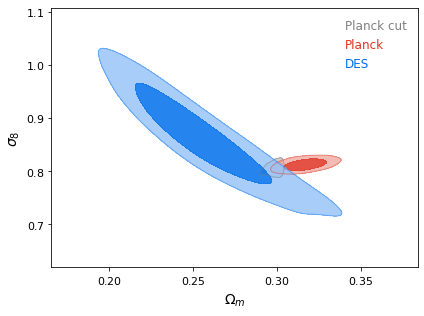

In [10]:
g = plots.get_single_plotter()
g.plot_2d([cutSamplesPlanck, samplesPlanck, samplesDES], ['omegam', 'sigma8'], filled=True)
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True)
# g.export('output_file.pdf')

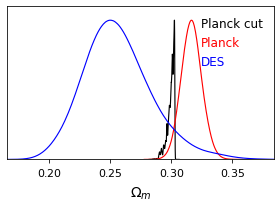

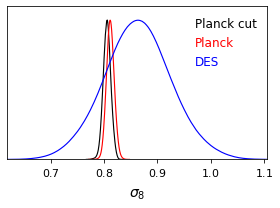

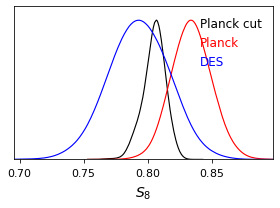

In [11]:
# Show the Omega_m tension
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'omegam', normalized=False)
# g.add_legend(['Planck', 'DES'], colored_text=False, legend_loc='upper right')
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# sigma_8 is consistent 
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'sigma8', normalized=False)
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# S8 is consistent 
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'S8', normalized=False)
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# Given a chain, compute Cl from the mean posterior parameters

This is where all the magic happens...

In [12]:
def getCl(samplesPlanck):
    
    # Convert parameter array into dictionary
    means = samplesPlanck.getMeans()
    paramIndices = samplesPlanck._getParamIndices()
    meansDict = {}
    for key in paramIndices.keys():
        iPar = paramIndices[key]
        meansDict[key] = means[iPar]
    
    # Convert to Cobaya input format
    fiducial_params = {
        'ombh2': meansDict['omegabh2'], 
        'omch2': meansDict['omegach2'], 
        'H0': meansDict['H0'], 
        'tau': meansDict['tau'],
        'As': meansDict['A'] * 1.e-9, 
        'ns': meansDict['ns']}

    
    packages_path = '/global/cscratch1/sd/eschaan/project_s8/code/cobaya_exploration/input/cobaya_packages'

    info_fiducial = {
        'params': fiducial_params,
        'likelihood': {'one': None},
        'theory': {'camb': {"extra_args": {"num_massive_neutrinos": 1}}},
        'packages_path': packages_path}

    l_max = 3000

    model_fiducial = get_model(info_fiducial)

    # Declare our desired theory product
    # (there is no cosmological likelihood doing it for us)
    model_fiducial.add_requirements({"Cl": {'tt': l_max, 'te': l_max, 'ee': l_max}})

    # Compute and extract the CMB power spectrum
    # (In muK^-2, without l(l+1)/(2pi) factor)
    # notice the empty dictionary below: all parameters are fixed
    model_fiducial.logposterior({})
    ClPlanck = model_fiducial.provider.get_Cl(ell_factor=False, units="muK2")

    # Our fiducial power spectrum
    ClTTPlanck = ClPlanck['tt'][:l_max + 1]
    ClTEPlanck = ClPlanck['te'][:l_max + 1]
    ClEEPlanck = ClPlanck['ee'][:l_max + 1]
    L = np.arange(l_max+1)
    
    return L, ClTTPlanck, ClTEPlanck, ClEEPlanck


## Compute Cl for the full Planck Chain

In [13]:
L, ClTTPlanck, ClTEPlanck, ClEEPlanck = getCl(samplesPlanck)

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


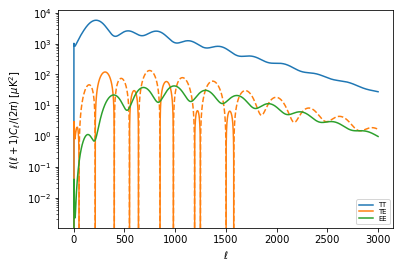

In [14]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.plot(L, L*(L+1.)/(2.*np.pi) * ClTTPlanck, label=r'TT')
plot=ax.plot(L, L*(L+1.)/(2.*np.pi) * ClTEPlanck, label=r'TE')
ax.plot(L, -L*(L+1.)/(2.*np.pi) * ClTEPlanck, ls='--', c=plot[0].get_color())
ax.plot(L, L*(L+1.)/(2.*np.pi) * ClEEPlanck, label=r'EE')
#
ax.legend(loc=4, fontsize='x-small', labelspacing=0.1)
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1) C_\ell / (2\pi)$ [$\mu$K$^2$]')

plt.show()

## Do it for the cut Planck chain and compare

In [15]:
L, ClTTPlanckCut, ClTEPlanckCut, ClEEPlanckCut = getCl(cutSamplesPlanck)

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


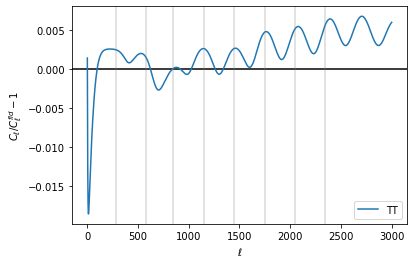

In [16]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClTTPlanckCut / ClTTPlanck - 1., label=r'TT')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**4*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**4*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
# ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()

/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


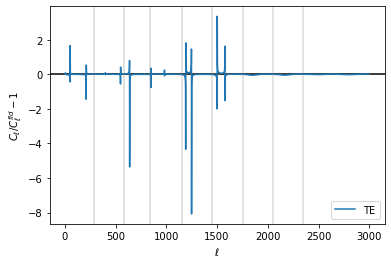

In [17]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClTEPlanckCut / ClTEPlanck - 1., label=r'TE')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**4*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**4*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
# ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()

/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


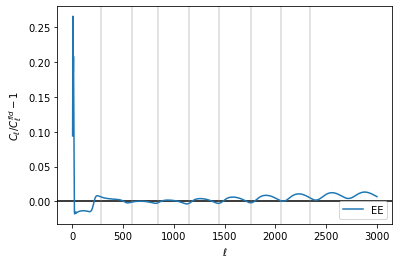

In [18]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClEEPlanckCut / ClEEPlanck - 1., label=r'EE')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**4*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**4*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()